# ОДУ второго порядка:
$$
\begin{cases}
\frac{d^2x}{dt^2} + \omega_0^2 x = \cos(\omega t) \\
x(0) = x_0 \\
\frac{dx}{dt}(0) = v_0
\end{cases}
$$

In [1]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

# Установка папки для сохранения по умолчанию
SAVE_DIR = "images"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_plot(filename: str, dpi=300):
    filepath = os.path.join(SAVE_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches="tight", transparent=True)

# Установка устройства для вычислений (CPU или GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Определение области определения
t_min, t_max = -5.0, 15.0

# Количество точек внутри области и на границе
num_interior = round((t_max - t_min) * 20)
x_interior = torch.linspace(t_min, t_max, num_interior).view(-1, 1).to(device)
x_interior.requires_grad = True

t = torch.linspace(t_min, t_max, num_interior).view(-1, 1).to(device)
t.requires_grad = True

x_boundary = torch.tensor([[0.0]], requires_grad=True).to(device)
y_boundary = torch.tensor([[0.0]], requires_grad=True).to(device)

In [3]:
# Определение нейронной сети
class Sine(nn.Module):
    def __init__(self):
        super(Sine, self).__init__()

    def forward(self, input):
        return torch.sin(2*input)

# Определение нейронной сети
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Задаем архитектуру: 3 скрытых слоя по 20 нейронов с функцией активации Tanh
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            Sine(),
            nn.Linear(20, 20),
            Sine(),
            nn.Linear(20, 20),
            Sine(),
            nn.Linear(20, 20),
            Sine(),
            nn.Linear(20, 20),
            Sine(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

Параметры для запуска:
 - $w = w_f = 2, f_a = 0.25, v_0 = 1$ для резонанса
 - $w = 2, w_f = 2.5, f_a = 2, v_0 = 1$ для его отсутствия

In [4]:
w = 2.0
w_f = 2.5
f_a = 2
v0 = 1

# Инициализация модели
model = PINN().to(device)

# Определение функции потерь
def loss_function(x_interior, x_boundary, y_boundary, y_boundary_dx, lambda_bc=1.0):
    # Предсказания модели на внутренних точках
    y_interior = model(x_interior)
    y_calc = model(x_boundary)

    # Вычисление производной dy/dx с помощью автоматического дифференцирования
    dy_dx = torch.autograd.grad(
        y_interior, x_interior,
        grad_outputs=torch.ones_like(y_interior),
        create_graph=True
    )[0]

    # Вычисление 2 производной dy/dx с помощью автоматического дифференцирования
    d2y_dx2 = torch.autograd.grad(
        dy_dx, x_interior,
        grad_outputs=torch.ones_like(dy_dx),
        create_graph=True
    )[0]

    # Вычисление функции дифференциального уравнения на внутренних точках (residual)
    residual = d2y_dx2 + (w**2) * y_interior + f_a * torch.cos(x_interior * w_f)

    # Предсказания модели на граничных точках
    yb_pred = model(x_boundary)

    diff_calc = torch.autograd.grad(
        y_calc, x_boundary,
        grad_outputs=torch.ones_like(y_calc),
        create_graph=True
    )[0]

    # Потери на уравнении (MSE по residual)
    loss_interior = torch.mean(residual**2)

    # Потери на граничных условиях (MSE между предсказанием и истинным значением)
    loss_boundary = torch.mean((yb_pred - y_boundary)**2) + torch.mean((diff_calc - y_boundary_dx)**2)

    # Общая функция потерь с учетом коэффициента lambda_bc
    loss = loss_interior + lambda_bc * loss_boundary # + punishment
    return loss

# Определение оптимизатора (Adam с шагом обучения lr = 1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Количество эпох обучения
num_epochs = 10000

# Список для хранения значений функции потерь
loss_history = []

y_boundary_dx = torch.tensor([[1.0]], requires_grad=True).to(device)
lambda_bc = 50

# Цикл обучения с использованием tqdm
best_loss = float('inf')
best_model_state_dict = None

pbar = tqdm(range(num_epochs), desc='Training', ncols=80)
for epoch in pbar:
    optimizer.zero_grad()
    loss = loss_function(t, x_boundary, y_boundary, y_boundary_dx, lambda_bc)

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state_dict = model.state_dict()

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    # Обновление отображения tqdm
    pbar.set_postfix({'Loss': f'{loss.item():.2e}'})

if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print(f"Restored the model with the best loss: {best_loss:.2e}")

Training:   0%|                                       | 0/10000 [00:00<?, ?it/s]

/home/andredon/projects/University/Practice3/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Restored the model with the best loss: 1.99e-05


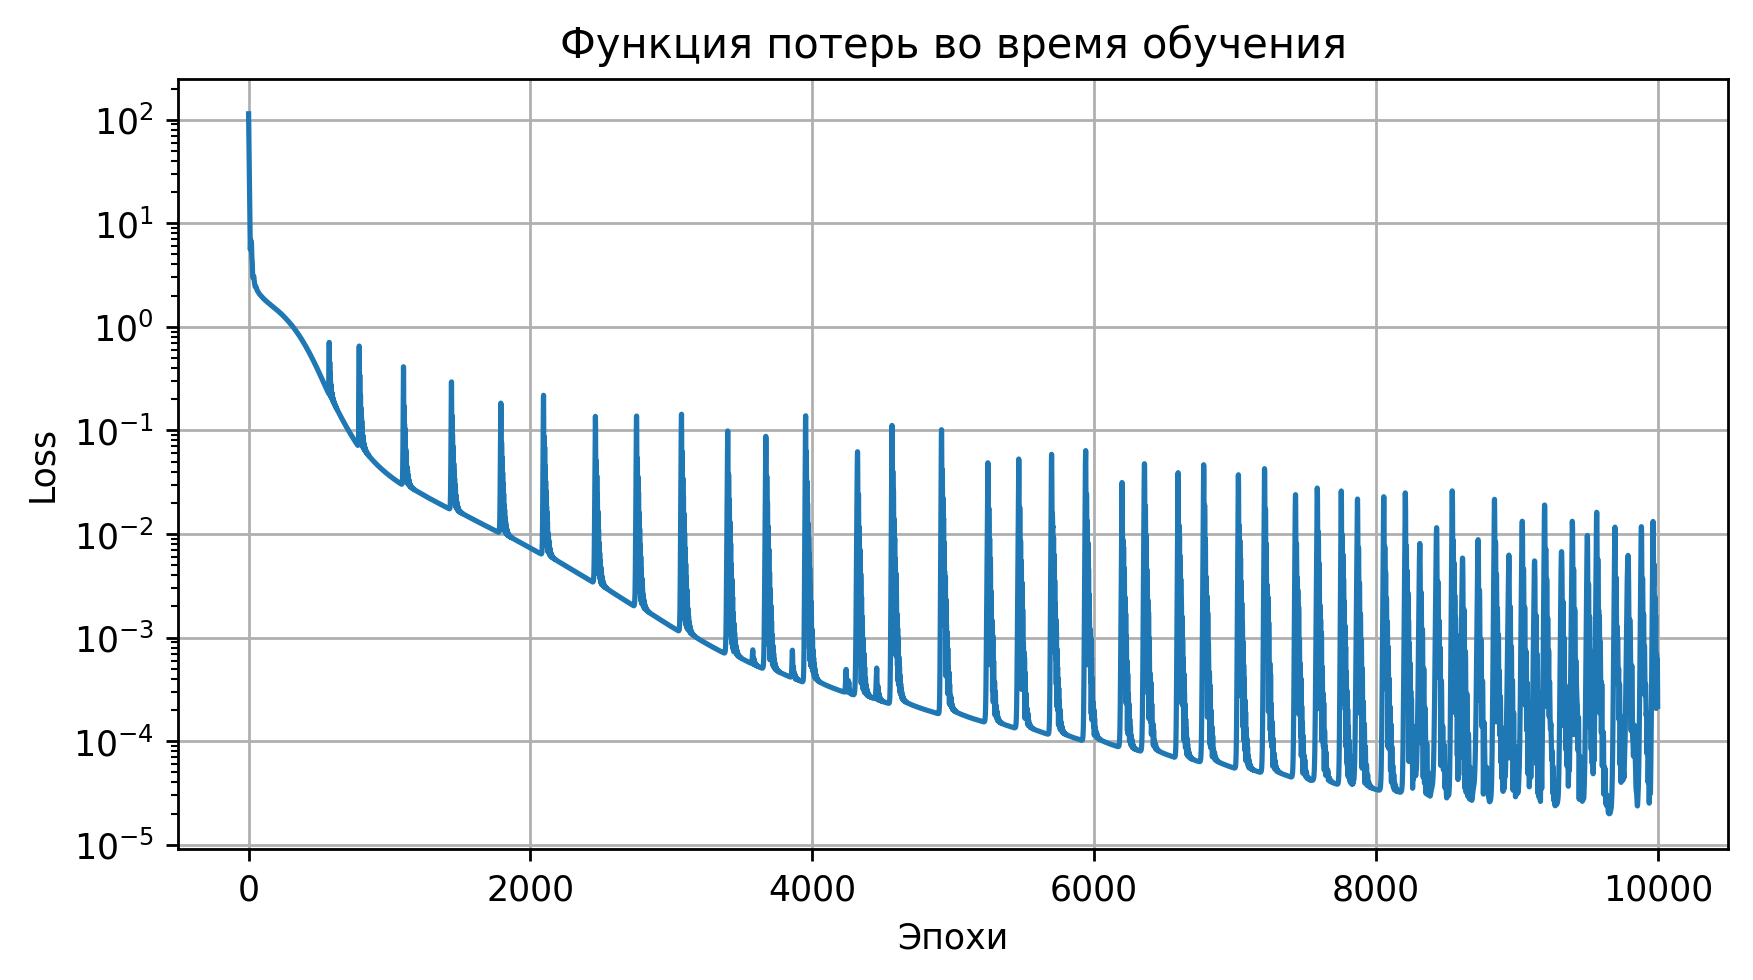

In [5]:
# Построение графика функции потерь в логарифмическом масштабе
plt.figure(figsize=(8, 4), dpi=250)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('Функция потерь во время обучения')
plt.grid(True)
save_plot("Loss_ODE_of_the_second_order.png")
plt.show()

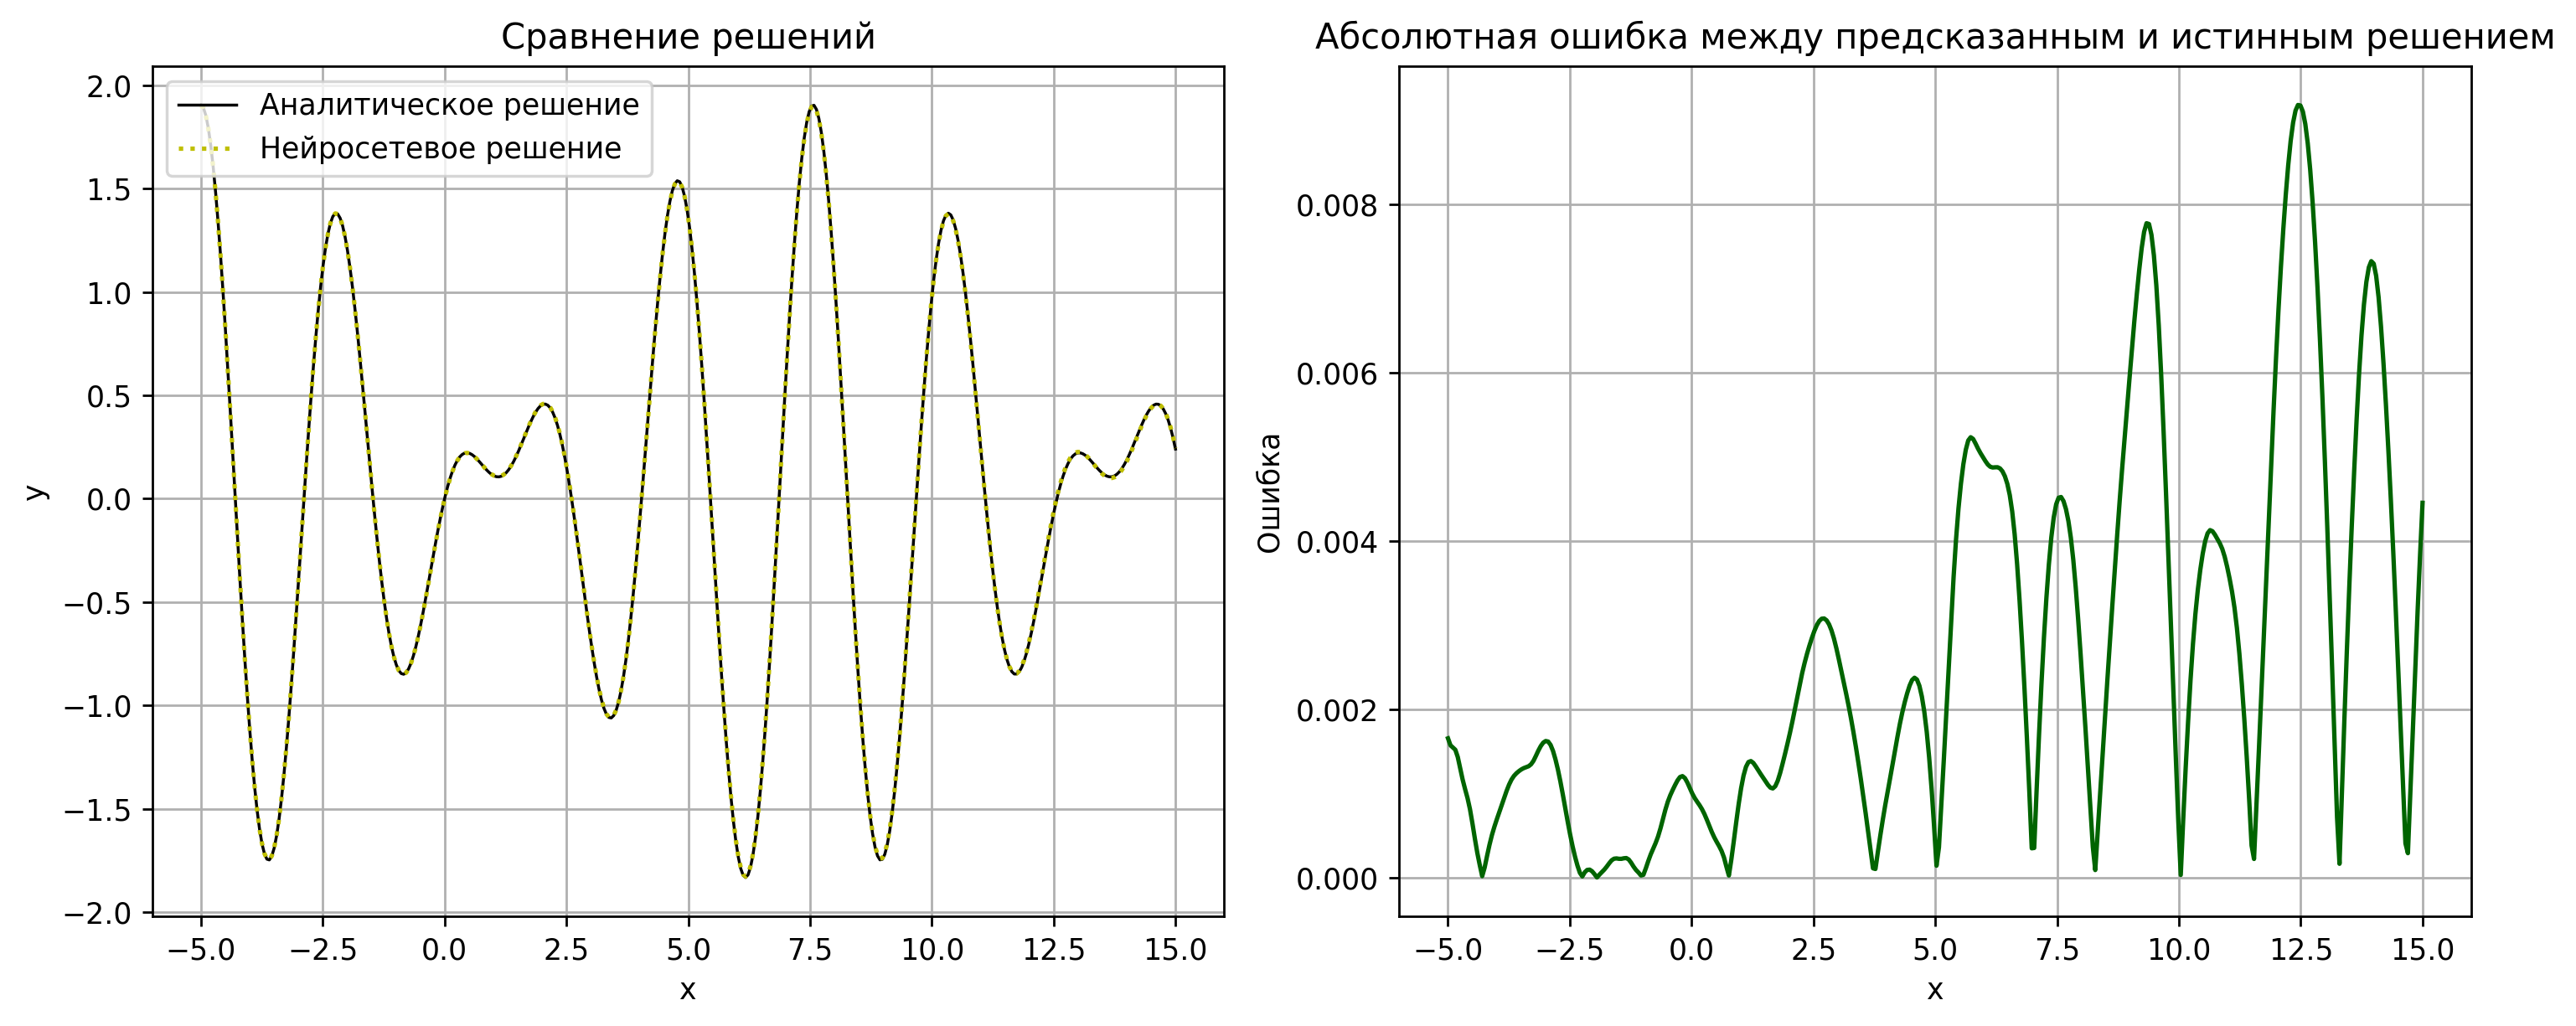

np.float32(0.0025928041)

In [6]:
x_l, x_r = -5, 15
cnt = 20
x_plot = torch.linspace(x_l, x_r , (x_r - x_l)*cnt).view(-1, 1).to(device)

# Аналитическое решение
x_p = x_plot.cpu().detach().numpy()
if w == w_f:
  y_true = (1/w - f_a*x_p/(2*w))*np.sin(w * x_p)
else:
  y_true = f_a*(np.cos(w * x_p) - np.cos(w_f * x_p))/(w**2 - w_f**2) + np.sin(w*x_p)/w

# Предсказание решения моделью
y_pred = model(x_plot).cpu().detach().numpy()[:, 0][:, np.newaxis]

x_plot = x_plot.cpu().detach().numpy()

# Вычисление абсолютной ошибки
absolute_error = np.abs(y_true - y_pred)

# Построение графиков
plt.figure(figsize=(12, 5), dpi=250)

# График предсказанного и истинного решения
plt.subplot(1, 2, 1)
plt.plot(x_plot, y_true, label='Аналитическое решение', linewidth = 1, color='k')
plt.plot(x_plot, y_pred, 'y:', label='Нейросетевое решение')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение решений')
plt.legend()
plt.grid(True)

# График абсолютной ошибки
plt.subplot(1, 2, 2)
plt.plot(x_plot, absolute_error, color='darkgreen')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.title('Абсолютная ошибка между предсказанным и истинным решением')
plt.grid(True)

plt.tight_layout()
save_plot("x_ODE_of_the_second_order.png")
plt.show()
np.mean(absolute_error)

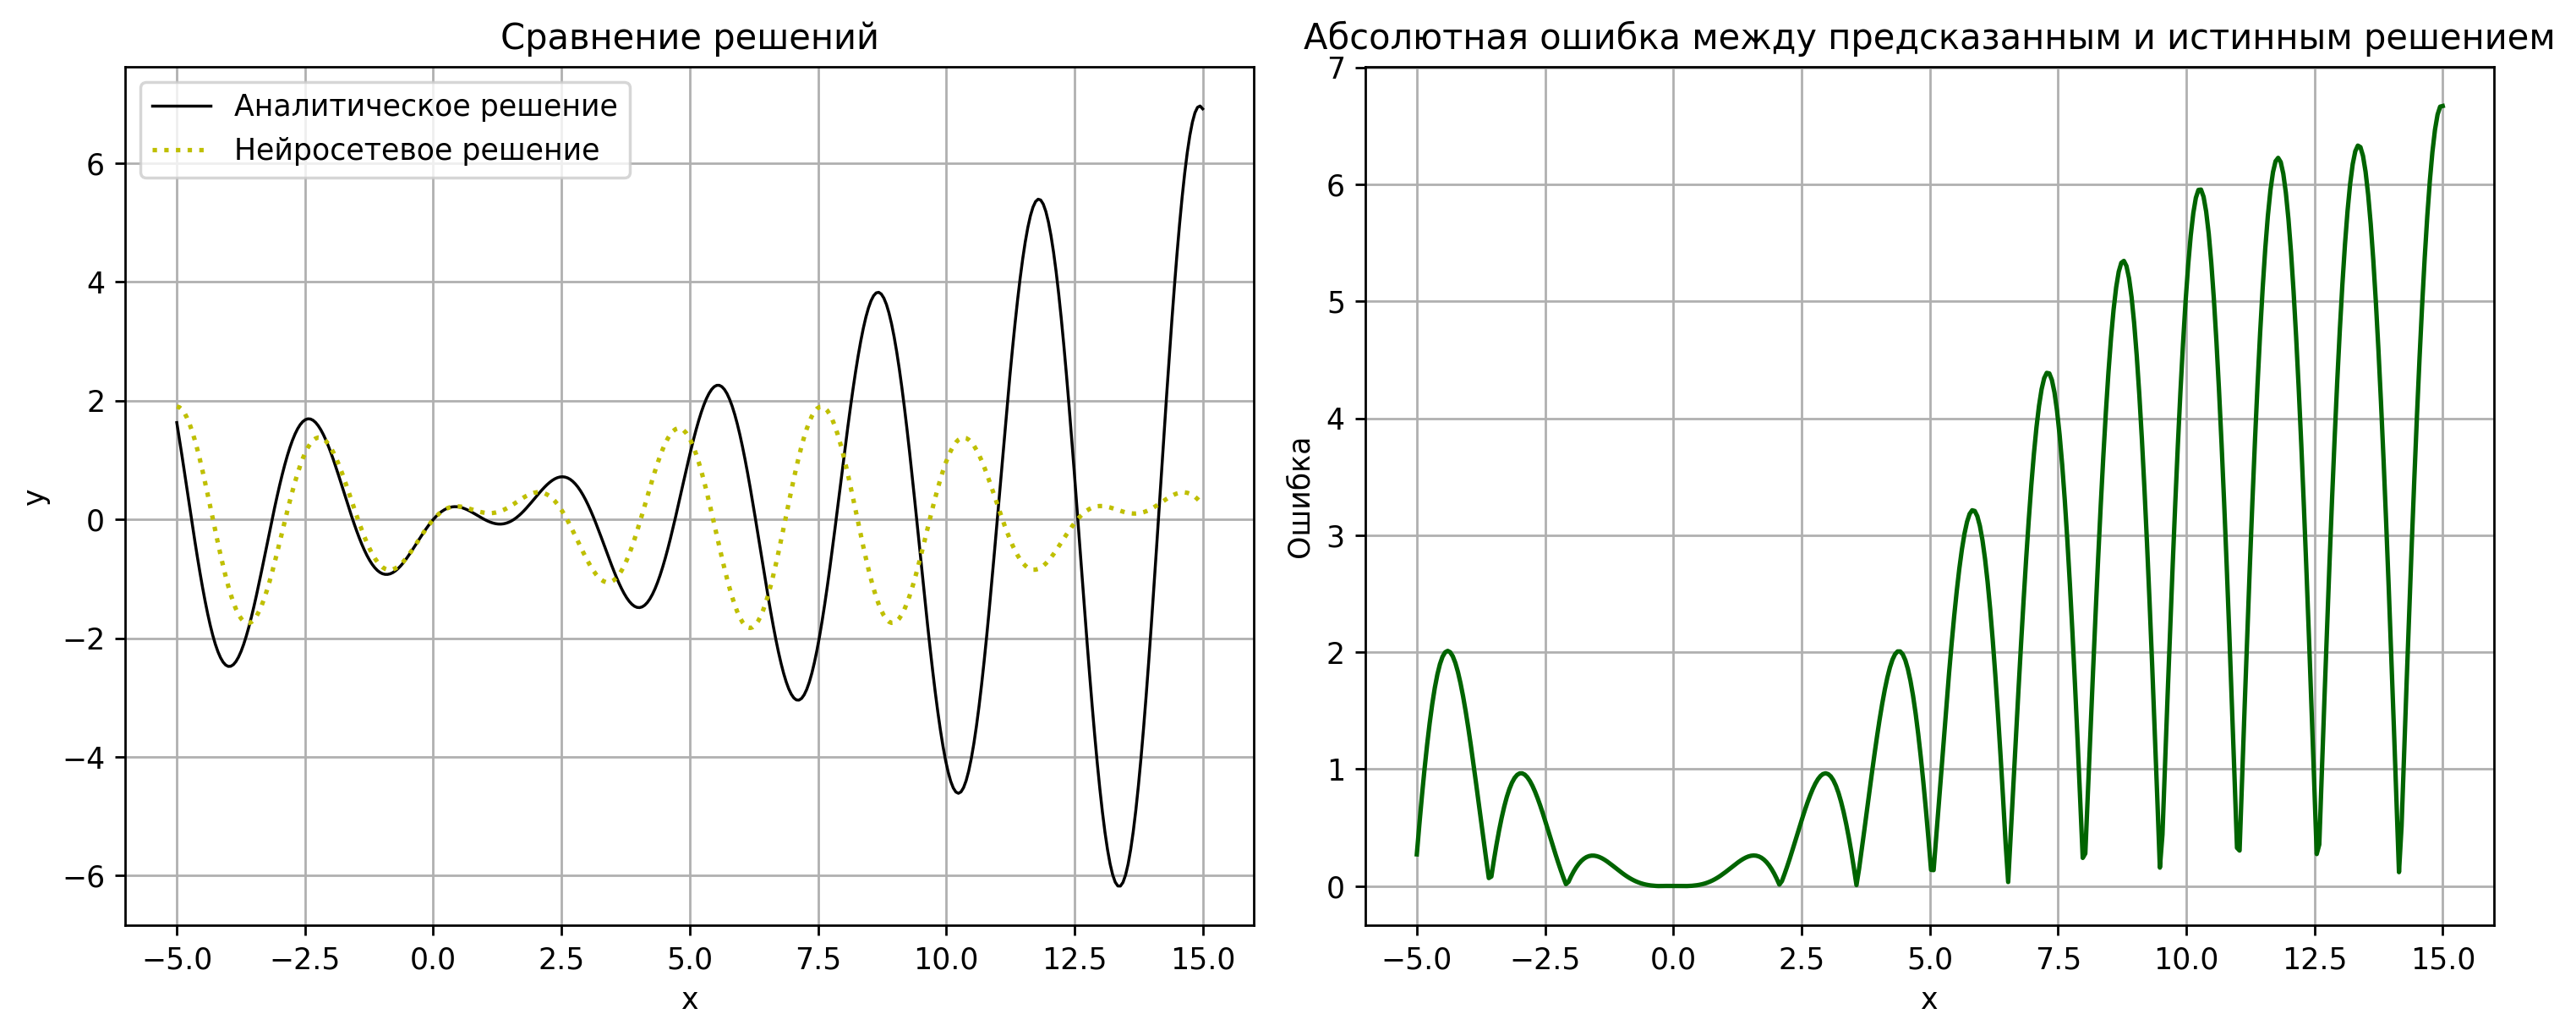

np.float32(2.00738)

In [7]:
# Точки для визуализации решения и ошибки
x_l, x_r = -5, 15
cnt = 20
x_plot = torch.linspace(x_l, x_r , (x_r - x_l)*cnt).view(-1, 1).to(device)

# Аналитическое решение
x_p = x_plot.cpu().detach().numpy()
y_true = (1/w - f_a*x_p/(2*w))*np.sin(w * x_p)

# Предсказание решения моделью
y_pred = model(x_plot).cpu().detach().numpy()

x_plot = x_plot.cpu().detach().numpy()

# Вычисление абсолютной ошибки
absolute_error = np.abs(y_true - y_pred)

# Построение графиков
plt.figure(figsize=(12, 5), dpi=250)

# График предсказанного и истинного решения
plt.subplot(1, 2, 1)
plt.plot(x_plot, y_true, label='Аналитическое решение', linewidth = 1, color='k')
plt.plot(x_plot, y_pred, 'y:', label='Нейросетевое решение')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение решений')
plt.legend()
plt.grid(True)

# График абсолютной ошибки
plt.subplot(1, 2, 2)
plt.plot(x_plot, absolute_error, color='darkgreen')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.title('Абсолютная ошибка между предсказанным и истинным решением')
plt.grid(True)

plt.tight_layout()
save_plot("v_ODE_of_the_second_order.png")
plt.show()
np.mean(absolute_error)